In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
csv_path = "dynamic_supply_chain_logistics_dataset.csv"   # <- change if needed

In [29]:
df = pd.read_csv(csv_path)

In [30]:
df.head()

,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [31]:
# Time features (safe and cheap)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month

In [32]:
# Convert timestamp column and extract parts
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month


In [33]:
def mm(x):
    x = x.astype(float)
    r = x.max() - x.min()
    return (x - x.min()) / r if r else x*0.0

traffic    = mm(df["traffic_congestion_level"])
weather    = mm(df["weather_condition_severity"])
port       = mm(df["port_congestion_level"])
customs    = mm(df["customs_clearance_time"])
route_risk = mm(df["route_risk_level"])
driver_bad = 1 - mm(df["driver_behavior_score"])      # worse behavior = more delay
fatigue    = mm(df["fatigue_monitoring_score"])
eta_var    = mm(df["eta_variation_hours"])
inventoryL = 1 - mm(df["warehouse_inventory_level"])  # low stock = more delay


In [34]:
traffic_weather = traffic * weather
port_customs    = port * customs

In [35]:
rng = np.random.default_rng(2025)
noise = rng.normal(0, 0.25, size=len(df))   # small random noise

df["delivery_time_deviation"] = (
    1.5
    + 2.2*traffic
    + 1.4*weather
    + 1.8*port
    + 2.4*customs
    + 1.6*route_risk
    + 1.2*driver_bad
    + 1.0*fatigue
    + 0.8*eta_var
    + 0.5*inventoryL
    + 1.3*traffic_weather
    + 1.1*port_customs
    + noise
)

# Ensure all values are positive
df["delivery_time_deviation"] = np.clip(df["delivery_time_deviation"], 0, None)


In [36]:
df.to_csv("enhanced_logistics_dataset.csv", index=False)
print("Enhanced dataset created and saved as 'enhanced_logistics_dataset.csv'")
print(df["delivery_time_deviation"].describe().round(3))


Enhanced dataset created and saved as 'enhanced_logistics_dataset.csv'
count    32065.000
mean         9.372
std          2.007
min          3.220
25%          7.937
50%          9.303
75%         10.756
max         16.354
Name: delivery_time_deviation, dtype: float64


In [37]:
corr = df.corr(numeric_only=True)["delivery_time_deviation"].sort_values(ascending=False)
print(corr.head(10))


delivery_time_deviation       1.000000
customs_clearance_time        0.544376
traffic_congestion_level      0.500096
weather_condition_severity    0.361857
port_congestion_level         0.360382
route_risk_level              0.260058
fatigue_monitoring_score      0.176052
eta_variation_hours           0.126412
supplier_reliability_score    0.008339
fuel_consumption_rate         0.005026
Name: delivery_time_deviation, dtype: float64


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [39]:
df = pd.read_csv("enhanced_logistics_dataset.csv")

In [40]:
df.isna().sum()

,0
timestamp,0
vehicle_gps_latitude,0
vehicle_gps_longitude,0
fuel_consumption_rate,0
eta_variation_hours,0
traffic_congestion_level,0
warehouse_inventory_level,0
loading_unloading_time,0
handling_equipment_availability,0
order_fulfillment_status,0


In [41]:
df.duplicated().sum()

np.int64(0)

In [42]:
df.describe()

,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,...,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,delivery_time_deviation,hour,dayofweek,month
count,32065.000000,32065.000000,32065.000000,32065.000000,3.206500e+04,3.206500e+04,32065.000000,3.206500e+04,32065.000000,3.206500e+04,...,32065.000000,32065.000000,3.206500e+04,3.206500e+04,32065.000000,32065.000000,32065.000000,32065.000000,32065.000000,32065.000000
mean,38.023589,-90.116648,8.011735,2.893068,4.991493e+00,2.992547e+02,2.291669,3.026954e-01,0.600740,4.976082e-01,...,7.001144,2.296448,4.983913e-01,6.008723e-01,0.803656,0.699077,9.372069,11.499641,3.000000,6.155746
std,6.917909,17.369244,4.264960,2.274044,3.532048e+00,3.234435e+02,1.554202,3.259146e-01,0.345672,3.532853e-01,...,3.236328,1.555932,3.541589e-01,3.458101e-01,0.279185,0.324514,2.006585,6.922484,2.000748,3.361877
min,30.000000,-119.999998,5.000000,-1.999993,1.091633e-09,1.322210e-12,0.500000,4.565769e-16,0.000001,4.536949e-09,...,0.000050,0.500000,4.043927e-09,3.269508e-07,0.000048,0.000003,3.220106,0.000000,0.000000,1.000000
25%,31.280550,-106.253913,5.019984,1.185744,1.474720e+00,1.605163e+01,0.774798,1.710828e-02,0.277096,1.440135e-01,...,4.593407,0.776166,1.443567e-01,2.783148e-01,0.693739,0.456009,7.936786,5.000000,1.000000,3.000000
50%,36.413820,-86.293414,5.636036,3.882059,4.981244e+00,1.572880e+02,1.917121,1.595151e-01,0.680553,4.961781e-01,...,8.385605,1.938273,4.988468e-01,6.831130e-01,0.958128,0.839599,9.302843,11.000000,3.000000,6.000000
75%,44.453655,-73.079367,9.669944,4.884355,8.534902e+00,5.405980e+02,3.734188,5.535954e-01,0.938160,8.498226e-01,...,9.836152,3.750817,8.510762e-01,9.372889e-01,0.998746,0.982391,10.755784,17.000000,5.000000,9.000000
max,50.000000,-70.000000,19.999875,5.000000,9.999999e+00,9.999993e+02,5.000000,9.999995e-01,1.000000,1.000000e+00,...,10.000000,5.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,16.354040,23.000000,6.000000,12.000000


In [43]:
key_features = ['traffic_congestion_level', 'port_congestion_level',
                'customs_clearance_time', 'disruption_likelihood_score',
                'delay_probability', 'driver_behavior_score',
                'fatigue_monitoring_score', 'weather_condition_severity'] # features

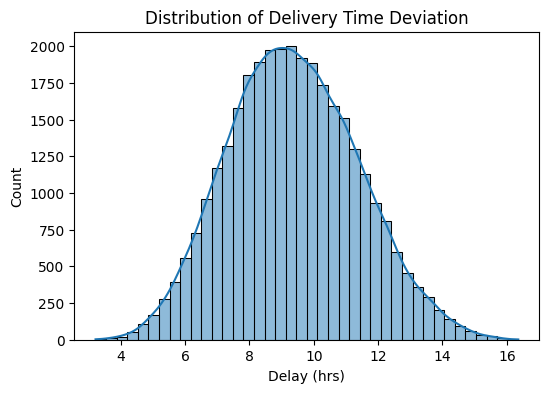

In [44]:
plt.figure(figsize=(6,4))
sns.histplot(df["delivery_time_deviation"], bins=40, kde=True)
plt.title("Distribution of Delivery Time Deviation")
plt.xlabel("Delay (hrs)")
plt.show()

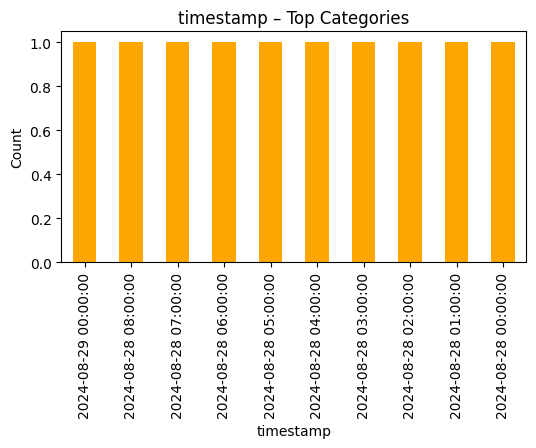

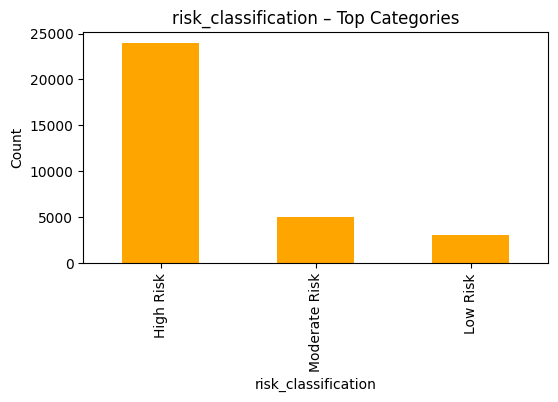

In [45]:
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    plt.figure(figsize=(6,3))
    df[col].value_counts().head(10).plot(kind='bar', color='orange') # Top_categories(categories variable analysis)
    plt.title(f'{col} – Top Categories')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

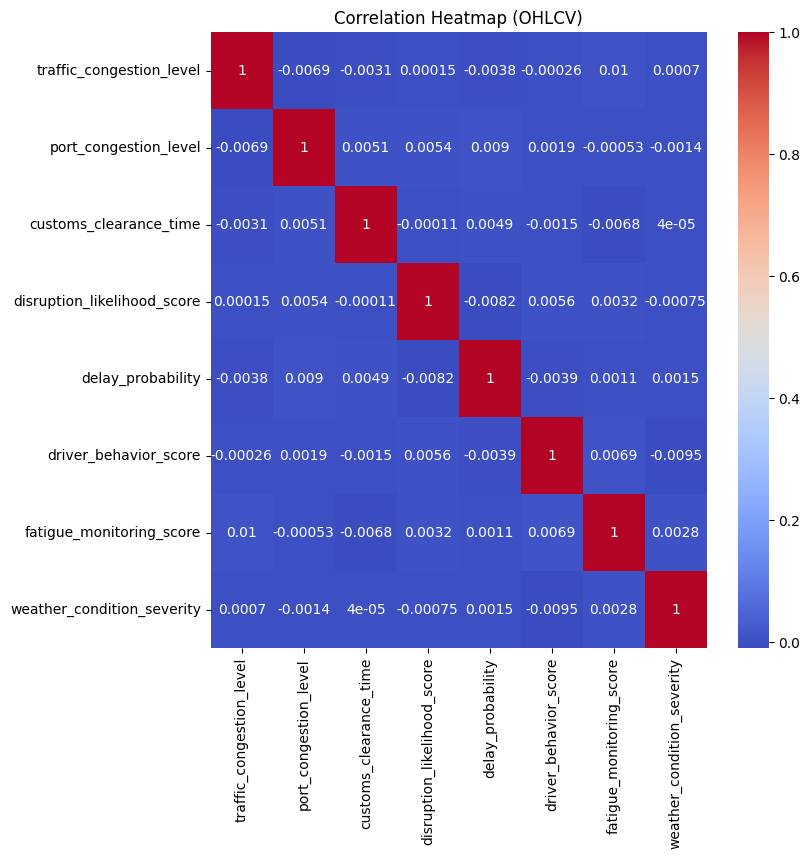

In [46]:
import seaborn as sns
corr = df[key_features].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="coolwarm") # corelation heathap for key features
plt.title("Correlation Heatmap (OHLCV)")
plt.show()

In [47]:
target = "delivery_time_deviation"
X = pd.get_dummies(
    df.drop(columns=["timestamp", target]),
    columns=["risk_classification"],
    drop_first=True)


In [48]:
y = df[target].astype(float)

# (Speed-safe) subsample 30–40% if needed
frac = 0.40
sub = X.sample(frac=frac, random_state= 42).index
X = X.loc[sub].reset_index(drop=True)
y = y.loc[sub].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 42)

X_train.shape, X_test.shape

((10260, 28), (2566, 28))

In [49]:
def add_indices(d):
    d = d.copy()
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1; dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        return 2*R*np.arcsin(np.sqrt(a))
    d["route_distance_km"] = haversine(
        d["vehicle_gps_latitude"],
        d["vehicle_gps_longitude"],
        d["vehicle_gps_latitude"].shift(-1).fillna(d["vehicle_gps_latitude"]),
        d["vehicle_gps_longitude"].shift(-1).fillna(d["vehicle_gps_longitude"])
    ).abs()
    d["route_distance_km"] = d["route_distance_km"].replace(0, d["route_distance_km"].median())
    d["fuel_per_km"] = d["fuel_consumption_rate"] / d["route_distance_km"]
    d["traffic_weather_index"] = d["traffic_congestion_level"] * d["weather_condition_severity"]
    d["port_customs_index"]    = d["port_congestion_level"]   * d["customs_clearance_time"]
    d["driver_fatigue_index"]  = d["driver_behavior_score"]   * d["fatigue_monitoring_score"]
    d["overall_risk_index"] = (
        d["route_risk_level"] + d["disruption_likelihood_score"] + d["delay_probability"]
    ) / 3
    d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")
    d["hour"] = d["timestamp"].dt.hour
    d["dayofweek"] = d["timestamp"].dt.dayofweek
    d["month"] = d["timestamp"].dt.month
    return d

df = add_indices(df)

target = "delivery_time_deviation"
X = pd.get_dummies(
    df.drop(columns=["timestamp", target]),
    columns=["risk_classification"],
    drop_first=True
)
y = df[target].astype(float)

In [50]:
# (Speed-safe) subsample 30–40% if needed
frac = 0.40
sub = X.sample(frac=frac, random_state=42).index
X = X.loc[sub].reset_index(drop=True)
y = y.loc[sub].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((10260, 34), (2566, 34))

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [52]:
def fit_eval(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) #  Removed squared=False and added np.sqrt
    r2   = r2_score(y_test, y_pred)
    print(f"{name:>24} - MAE={mae:.4f}  RMSE={rmse:.4f}  R²={r2:.4f}")
    return name, y_pred, mae, rmse, r2

In [53]:
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.06, max_depth=3, random_state = 42)
m1 = fit_eval(gbr, "Gradient Boosting")

       Gradient Boosting - MAE=0.2492  RMSE=0.3099  R²=0.9764


In [54]:
etr = ExtraTreesRegressor(n_estimators=200, max_depth=15, random_state= 42, n_jobs=-1)
m2 = fit_eval(etr, "Extra Trees")

             Extra Trees - MAE=0.3577  RMSE=0.4493  R²=0.9503


In [55]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=14, random_state= 42, n_jobs=-1)
m3 = fit_eval(rfr, "Random Forest")

           Random Forest - MAE=0.3934  RMSE=0.4937  R²=0.9400


In [56]:
hgb = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.08, max_iter=200, random_state = 42)
m4 = fit_eval(hgb, "HistGradientBoosting")

    HistGradientBoosting - MAE=0.2445  RMSE=0.3061  R²=0.9769


In [65]:
rows = []
for name, y_pred, mae, rmse, r2 in [m1, m2, m3, m4]:
    rows.append({"Model": name, "MAE (hrs)": mae, "RMSE (hrs)": rmse, "R²": r2})
results = pd.DataFrame(rows).sort_values("RMSE (hrs)").reset_index(drop=True)
print("Model Comparison ")
print(results.round(4).to_string(index=False))

best_name = results.iloc[0]["Model"]
model_preds = {m_tuple[0]: m_tuple[1] for m_tuple in [m1, m2, m3, m4]}
best_pred = model_preds[best_name]
pd.DataFrame({"y_actual": y_test.values, "y_pred": best_pred}).to_csv(f"{best_name.replace(' ','_').lower()}_preds.csv", index=False)

Model Comparison 
               Model  MAE (hrs)  RMSE (hrs)     R²
HistGradientBoosting     0.2445      0.3061 0.9769
   Gradient Boosting     0.2492      0.3099 0.9764
         Extra Trees     0.3577      0.4493 0.9503
       Random Forest     0.3934      0.4937 0.9400


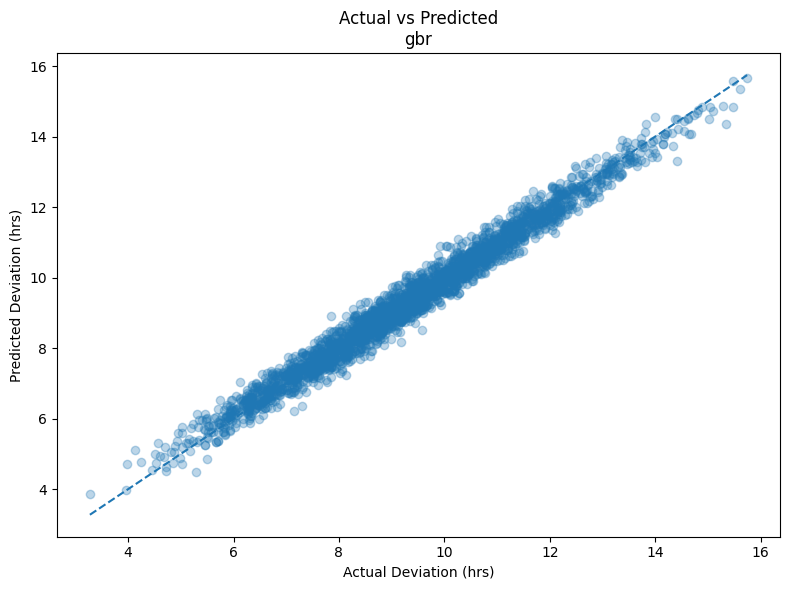

In [70]:
plt.figure(figsize=(8,6)) # Gradient Boosting Model
plt.scatter(y_test,y_pred, alpha=0.3)
low = min(y_test.min(), best_pred.min())
high = max(y_test.max(), best_pred.max())
plt.plot([low, high], [low, high], linestyle="--")
plt.xlabel("Actual Deviation (hrs)")
plt.ylabel("Predicted Deviation (hrs)")
plt.title(f"Actual vs Predicted\n{'gradient Boosting Model'}")
plt.tight_layout()
plt.show()

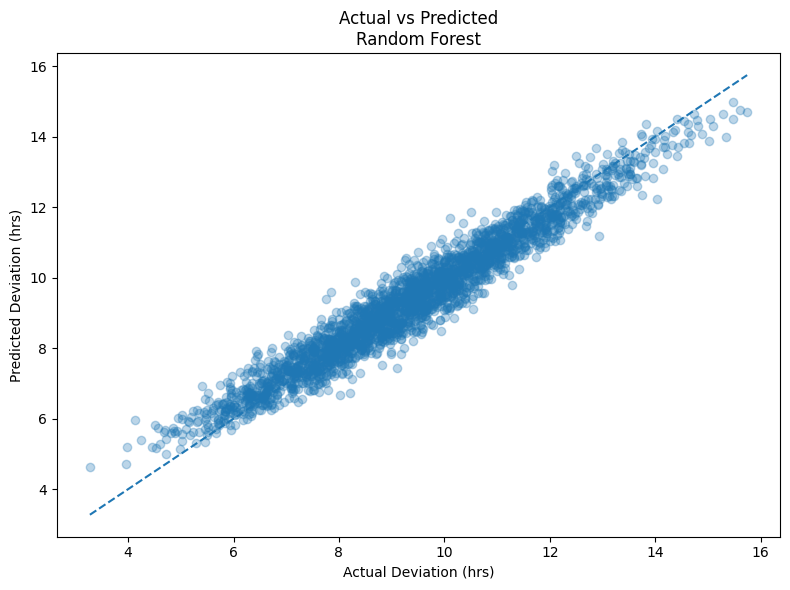

In [59]:
rfr_name = "Random Forest"
rfr_pred = model_preds[rfr_name]
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rfr_pred, alpha=0.3)
low = min(y_test.min(), rfr_pred.min())
high = max(y_test.max(), rfr_pred.max())
plt.plot([low, high], [low, high], linestyle="--")
plt.xlabel("Actual Deviation (hrs)")
plt.ylabel("Predicted Deviation (hrs)")
plt.title(f"Actual vs Predicted\n{rfr_name}")
plt.tight_layout()
plt.show()

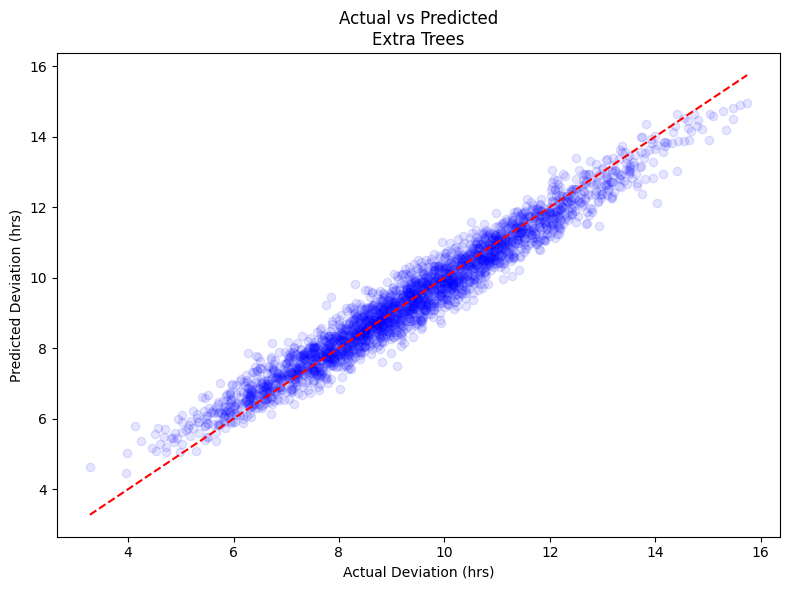

In [60]:
etr_name = "Extra Trees"
etr_pred = model_preds[etr_name]

plt.figure(figsize=(8, 6))
plt.scatter(y_test, etr_pred, alpha=0.1,color = 'blue')
low = min(y_test.min(), etr_pred.min())
high = max(y_test.max(), etr_pred.max())
plt.plot([low, high], [low, high], linestyle="--",color = 'red')
plt.xlabel("Actual Deviation (hrs)")
plt.ylabel("Predicted Deviation (hrs)")
plt.title(f"Actual vs Predicted\n{etr_name}")
plt.tight_layout()
plt.show()

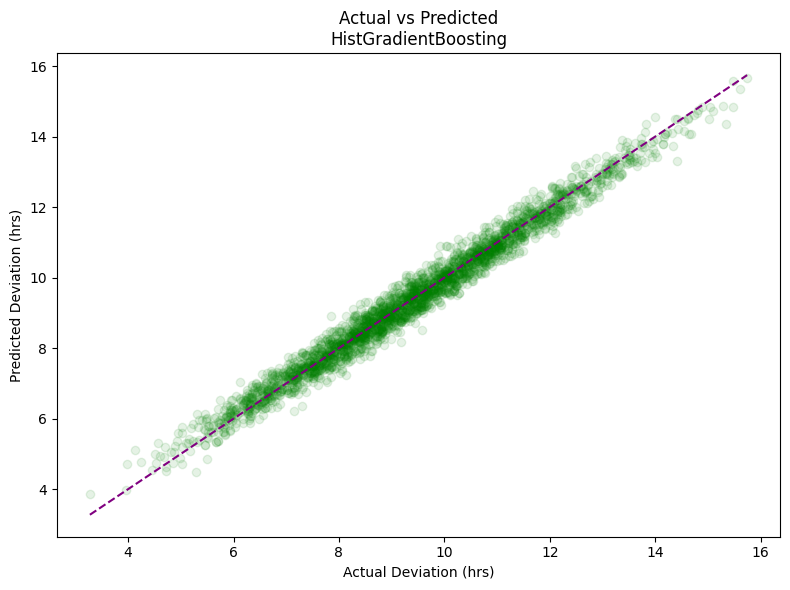

In [61]:
hgb_name = m4[0]
hgb_pred = m4[1]
plt.figure(figsize=(8, 6))
plt.scatter(y_test, hgb_pred, alpha=0.1, color='green')
low = min(y_test.min(), hgb_pred.min())
high = max(y_test.max(), hgb_pred.max())
plt.plot([low, high], [low, high], linestyle="--", color='purple')
plt.xlabel("Actual Deviation (hrs)")
plt.ylabel("Predicted Deviation (hrs)")
plt.title(f"Actual vs Predicted\n{hgb_name}")
plt.tight_layout()
plt.show()

In [67]:
comparison_df = pd.DataFrame({
    'Actual Deviation (hrs)': y_test.values,
    'Predicted Deviation (hrs)': y_pred
})

# Round for cleaner display
comparison_df['Actual Deviation (hrs)'] = comparison_df['Actual Deviation (hrs)'].round(0).astype(int)
comparison_df['Predicted Deviation (hrs)'] = comparison_df['Predicted Deviation (hrs)'].round(0).astype(int)

# Show first 10 rows
comparison_df.tail(10)

,Actual Deviation (hrs),Predicted Deviation (hrs)
2556,10,9
2557,13,13
2558,8,7
2559,12,12
2560,11,11
2561,14,15
2562,12,12
2563,11,11
2564,12,12
2565,12,12


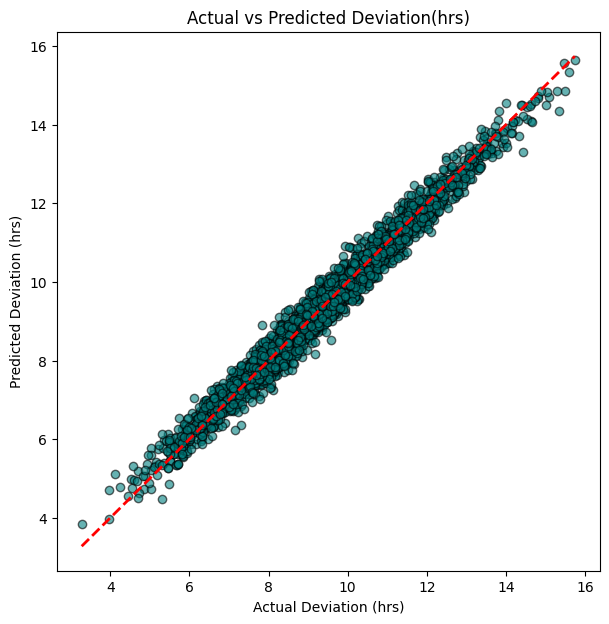

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test,y_pred, alpha=0.6, color='teal', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Deviation (hrs)")
plt.ylabel("Predicted Deviation (hrs)")
plt.title("Actual vs Predicted Deviation(hrs)")
plt.show()

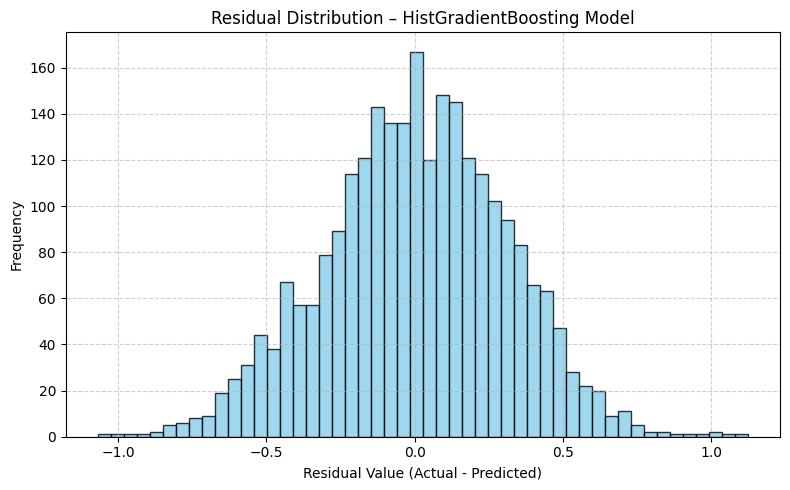

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(
    y_test - hgb_pred,
    bins=50,
    color='skyblue',
    edgecolor='black',
    alpha=0.8,
    density=False)
plt.xlabel("Residual Value (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – HistGradientBoosting Model")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()